# NYC Bus Analysis - Data Analysis & Visualization

This analysis is based on the Kaggle dataset 'New York City Bus Data' provided by Michael Stone. The purpose of this exercise is to get a better understanding of bus delays in various areas of New York City and attempt to predict bus delays in the future.

This notebook is dedicated to data analysis and visualization.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gmplot
import sklearn.cross_validation as cv
from sklearn import neighbors as nb
from IPython.display import Image

%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
%store -r dataset

In [15]:
dataset.head()

RecordedAtTime  DirectionRef PublishedLineName  \
0  2017-06-01 00:03:34             0                B8   
1  2017-06-01 00:03:43             1               S61   
2  2017-06-01 00:03:49             0              Bx10   
3  2017-06-01 00:03:31             0                Q5   
4  2017-06-01 00:03:22             1               Bx1   

                  OriginName  OriginLat  OriginLong  \
0                 4 AV/95 ST  40.616104  -74.031143   
1  ST GEORGE FERRY/S61 & S91  40.643169  -74.073494   
2     E 206 ST/BAINBRIDGE AV  40.875008  -73.880142   
3           TEARDROP/LAYOVER  40.701748  -73.802399   
4      RIVERDALE AV/W 231 ST  40.881187  -73.909340   

                   DestinationName  DestinationLat  DestinationLong  \
0          BROWNSVILLE ROCKAWAY AV       40.656048       -73.907379   
1                S I MALL YUKON AV       40.575935       -74.167686   
2                 RIVERDALE 263 ST       40.912376       -73.902534   
3    ROSEDALE LIRR STA via MERRICK       40.666012       -73.735939   
4  MOTT HAVEN 136 ST via CONCOURSE       40.809654       -73.928360   

  VehicleRef  VehicleLocation.Latitude  VehicleLocation.Longitude  \
0   NYCT_430                 40.635170                 -73.960803   
1  NYCT_8263                 40.590802                 -74.158340   
2  NYCT_4223                 40.886010                 -73.912647   
3  NYCT_8422                 40.668002                 -73.729348   
4  NYCT_4710                 40.868134                 -73.893032   

             NextStopPointName ArrivalProximityText  DistanceFromStop  \
0            FOSTER AV/E 18 ST          approaching              76.0   
1      MERRYMOUNT ST/TRAVIS AV          approaching              62.0   
2  HENRY HUDSON PKY E/W 235 ST              at stop               5.0   
3     HOOK CREEK BL/SUNRISE HY        < 1 stop away             267.0   
4     GRAND CONCOURSE/E 196 ST              at stop              11.0   

   ExpectedArrivalTime ScheduledArrivalTime ExpectedArrivalHour  \
0  2017-06-01 00:03:59             00:06:14            00:03:59   
1  2017-06-01 00:03:56             23:58:02            00:03:56   
2  2017-06-01 00:03:56             00:00:53            00:03:56   
3  2017-06-01 00:04:03             00:03:00            00:04:03   
4  2017-06-01 00:03:56             23:59:38            00:03:56   

   Delay_Seconds  Delay_Minutes  
0            135            2.0  
1           -354           -6.0  
2           -183           -3.0  
3            -63           -1.0  
4           -258           -4.0

### Step 1: Classifying Data

Given that this is a fairly large dataset (>5 million rows), it is not possible to view each line and understand characteristics of each line. As I am interested in bus delays, I wanted to understand if longer delays are more common in a particular area (based on bus location latitude and longitude) or if buses starting from a particular origin or reaching a particular destination experienced more delay. There could also be other trends in the data. In order uncover the trends, I felt that a good starting point is to classify the data into groups.

The approach I've taken is K-Nearest Neighbors. This algorithm is based on the idea that rows of data values that share similar characteristics are located close to each other.

In [16]:
cluster_data = dataset

In [17]:
cluster_data = cluster_data.sort_values('Delay_Seconds')
cluster_data = cluster_data.reset_index(drop=True)

I am using 3 nearest neighbors. I identify 3 default groups: group 0 with delay longer than 300 seconds, group 1 with delay between 0 and 300 seconds, group 2 with no delay. The groups are denoted by the column 'label'.

In [18]:
cluster_data['label'] = -1

In [19]:
cluster_data['label'][cluster_data['Delay_Seconds'] < -300] = 0
cluster_data['label'][cluster_data['Delay_Seconds'].between(-300,0)] = 1
cluster_data['label'][cluster_data['Delay_Seconds']>0] = 2

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


The x axis is all the values of selected columns and the y axis is the labels.

In [20]:
x = cluster_data.loc[:, ['OriginLat','OriginLong','DestinationLat','DestinationLong','VehicleLocation.Latitude','VehicleLocation.Longitude','DistanceFromStop','Delay_Seconds']]
y = cluster_data['label']

75% of the data is part of the training set and 25% of data is part of the testing set. In other words, the K-Nearest Neighbors alogrithm will be applied on 75% of the data. The results will identify the characteristics of the three groups 0, 1  and 2 that we have assigned above (see group information below). Based on the results obtained, the model will applied to the testing set. We will then calculate how closely the model fits the training data.

group 0: delay longer than 300 seconds <br>
group 1: delay between 0 and 300 seconds <br>
group 2: no delay

In [21]:
(x_train, x_test, y_train, y_test) = cv.train_test_split(x, y, test_size=.25)

In [22]:
# The number of neighbors affects performance
nbrs = 3

# First we construct our Classification Model
knc = nb.KNeighborsClassifier(n_neighbors=nbrs)
knc.fit(x_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

The prediction accuracy is 100%. In other words, the model developed using the training data seems to be able to match the testing data entirely. 


In [23]:
print("KNN ({0} neighbors) prediction accuracy = {1:5.1f}%".format(nbrs, 100.0 * knc.score(x_test, y_test)))

KNN (3 neighbors) prediction accuracy = 100.0%


Usually, prediction accuracy is close to 100% if a model works well. However, if the prediction accuracy is 100%, this suggests that attributes in the data other than delay, such as 'OriginLat', 'OriginLong', 'DestinationLat', 'DestinationLong', 'VehicleLocation.Latitude', 'VehicleLocation.Longitude', 'DistanceFromStop', 'Delay_Seconds' are not varying by the duration of delay.

Upon exploring how latitudes and longitudes are assigned to a particular location on Google maps, I understood the latitude and longitude values vary by very little in one city. As a result, it makes sense that OriginLat', 'OriginLong', 'DestinationLat', 'DestinationLong', 'VehicleLocation.Latitude', 'VehicleLocation.Longitude', did not vary much by duration of delay.

In addition, 'DistanceFromStop' might be similar for all 3 groups (see group information below) given that a bus can be delayed by any amount and still be close to or further away from a stop. Also, since the data has several readings taken at multiple times during the day, each group might have a similar varity of 'DistanceFromStop' values.

group 0: delay longer than 300 seconds <br>
group 1: delay between 0 and 300 seconds <br>
group 2: no delay

In other words, we are not able to obtain useful information about the characteristics of each group. Classify the data using the K-Nearest Neighbors algorithm is not a useful technique in this case.

### Step 2: Which locations have the greatest number of buses?**

The data contains the location of buses at multiple times during the day. I wanted to know where most buses were located in the month of June to get a general sense for where the bus delays would be. 

By using the gmplot package, I created a heatmap of bus location frequency. Locations that had more buses were covered in red for a larger area.

In [24]:
latitudes = dataset['VehicleLocation.Latitude']
longitudes = dataset ['VehicleLocation.Longitude']

The image belows shows bus location frequency for the month of June. The most number of buses were in Manhattan, followed by Brooklyn and Staten Island. Buses were frequent throughout Manhattan given by the multiple larger red regions. This could be an indication that most number of bus delays could be in Manhattan. It is interesting to note that buses did not service certain areas, as given by the green regions.

The green rectangular region, marked by a circle, right by Upper East Side does not have buses going through it, as this location corresponds to Central Park, which does not have roads for buses inside it.

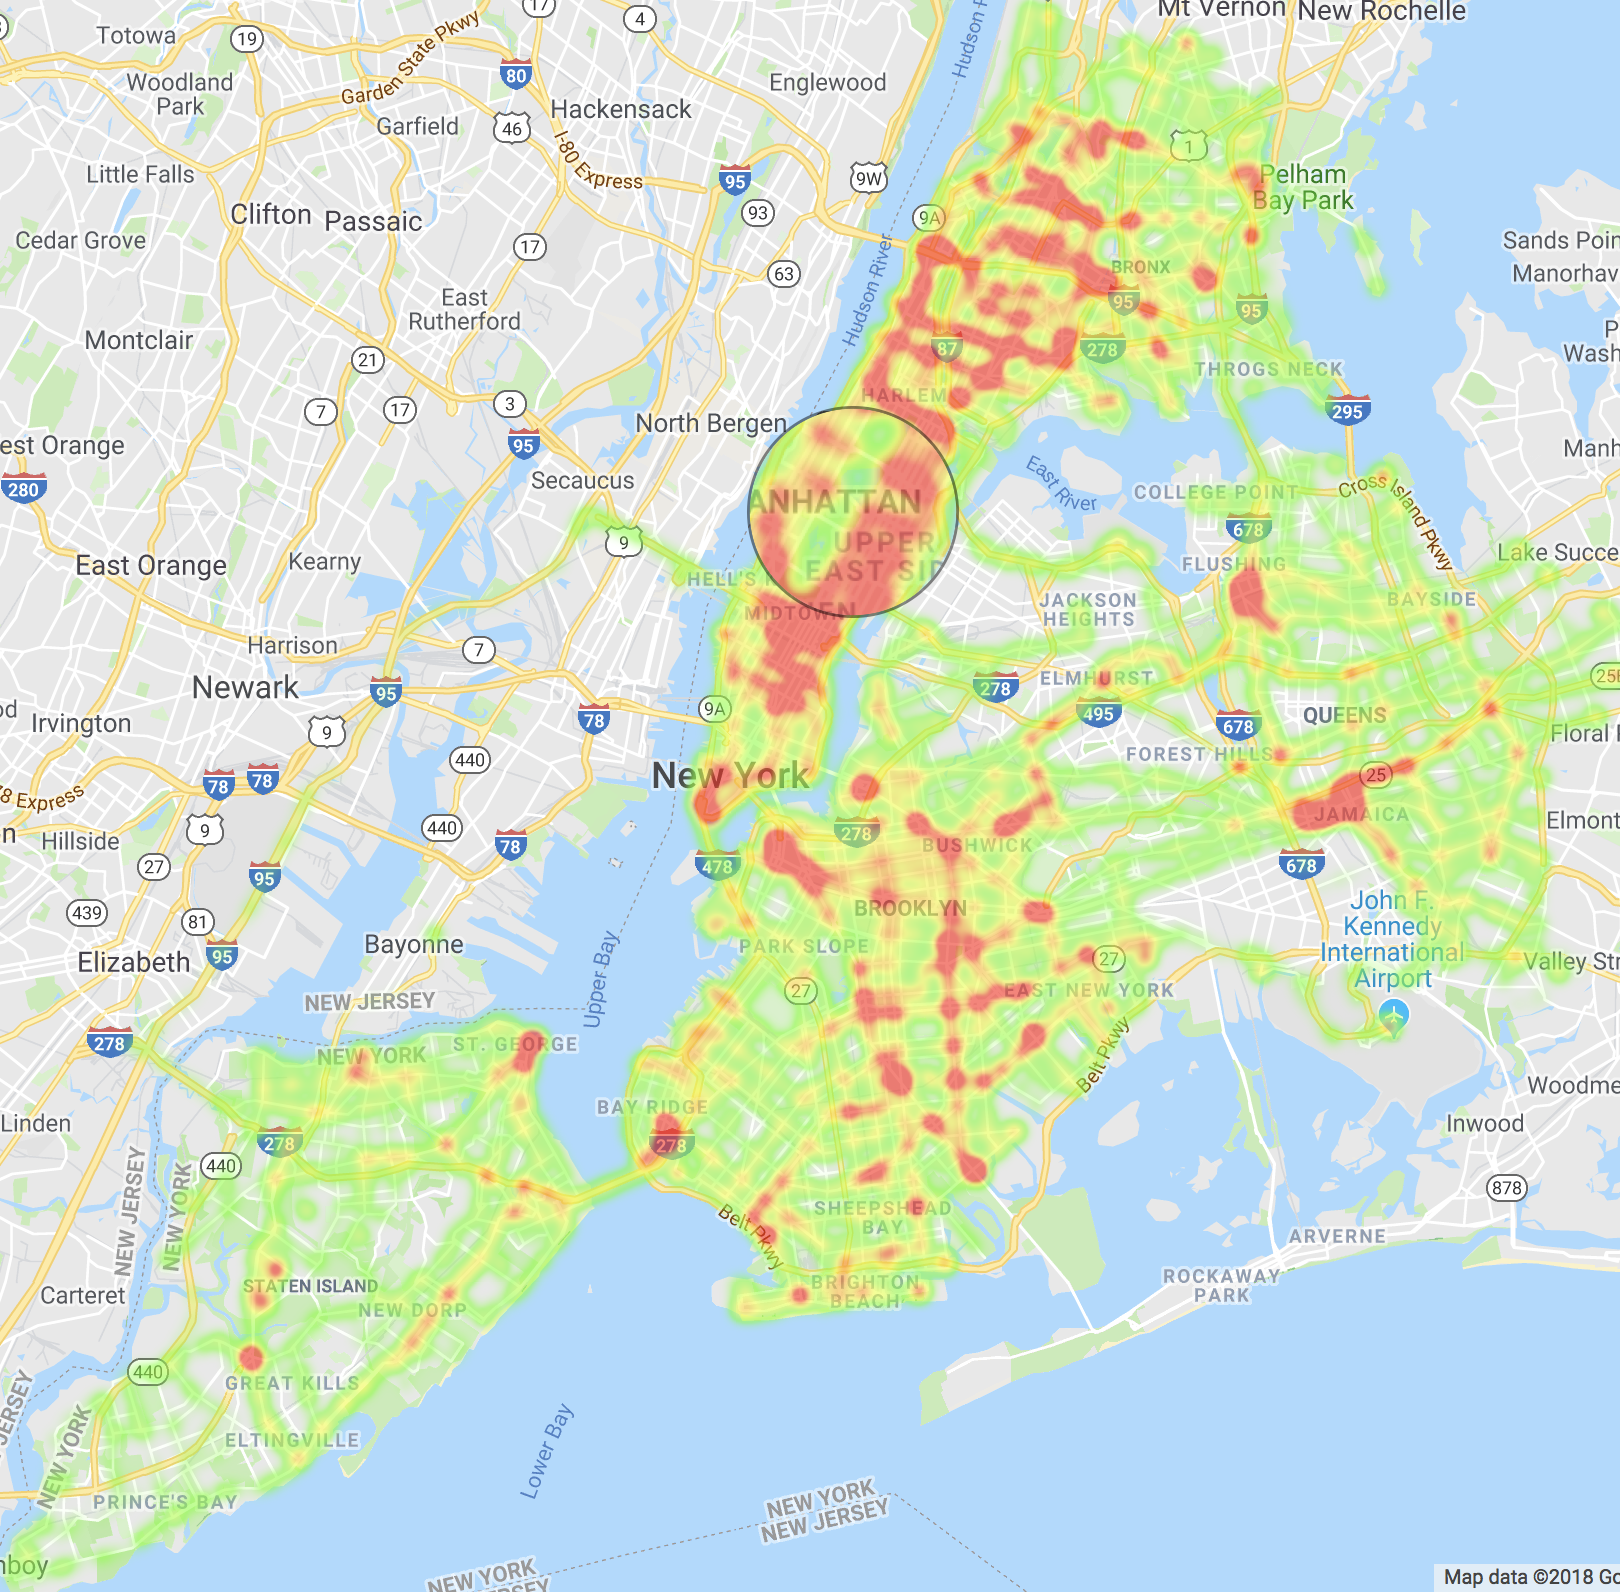

In [25]:
gmap = gmplot.GoogleMapPlotter(40.635170, -73.960803, 10)
gmap.heatmap(latitudes, longitudes)
gmap.draw("bus_heatmap.html")
Image(filename='Bus_location_heatmap.png') 

### Step 3: Understanding 'DirectionRef'

The column 'DirectionRef' has either 0 or 1 as a value across the 5 million rows. I wanted to understand whether 'DirectionRef' was common to all buses and inturn whether traffic and delays were more common in 1 direction than another. The following visualization is for 2 buses B1 and B11. Bus numbers are based on the 'PublishedLineName' column. The lines shown below connect the origin latitude and longitude to the destination latitude and longitude in 'DirectionRef' = 0 and 'DirectionRef' = 1 for each bus.

The visualization reveals that 'DirectionRef' is not common across buses and is specific to the route taken by each bus.

In [26]:
# Information for bus B1
latitude_list1 = [ 40.578325, 40.618942 ] 
longitude_list1 = [ -73.939931, -74.023720 ] 

latitude_list2 = [ 40.619363, 40.578094 ] 
longitude_list2 = [ -74.024355, -73.940170 ] 

#Information for B11
latitude_list3 = [ 40.645403, 40.632011 ] 
longitude_list3 = [ -74.022795, -73.947723 ] 

latitude_list4 = [ 40.631992, 40.645618 ] 
longitude_list4 = [ -73.946701, -74.023521] 
  
gmap3 = gmplot.GoogleMapPlotter(40.578325, -73.939931, 13) 

gmap3.scatter(latitude_list1, longitude_list1,'# FF0000', 
                              size = 40, marker = False ) 

gmap3.plot(latitude_list1, longitude_list1,  
           'cornflowerblue', edge_width = 2.5) 

gmap3.scatter( latitude_list2, longitude_list2, '# FF0000', 
                              size = 40, marker = False ) 
  
gmap3.plot(latitude_list2, longitude_list2,  
           'cornflowerblue', edge_width = 2.5) 

gmap3.scatter( latitude_list3, longitude_list3, '# FF0000', 
                              size = 40, marker = False ) 
   
gmap3.plot(latitude_list3, longitude_list3,  
           'cornflowerblue', edge_width = 2.5) 

gmap3.scatter( latitude_list4, longitude_list4, '# FF0000', 
                              size = 40, marker = False ) 
  
gmap3.plot(latitude_list4, longitude_list4,  
           'cornflowerblue', edge_width = 2.5) 
  
gmap3.draw("my_map12.html")

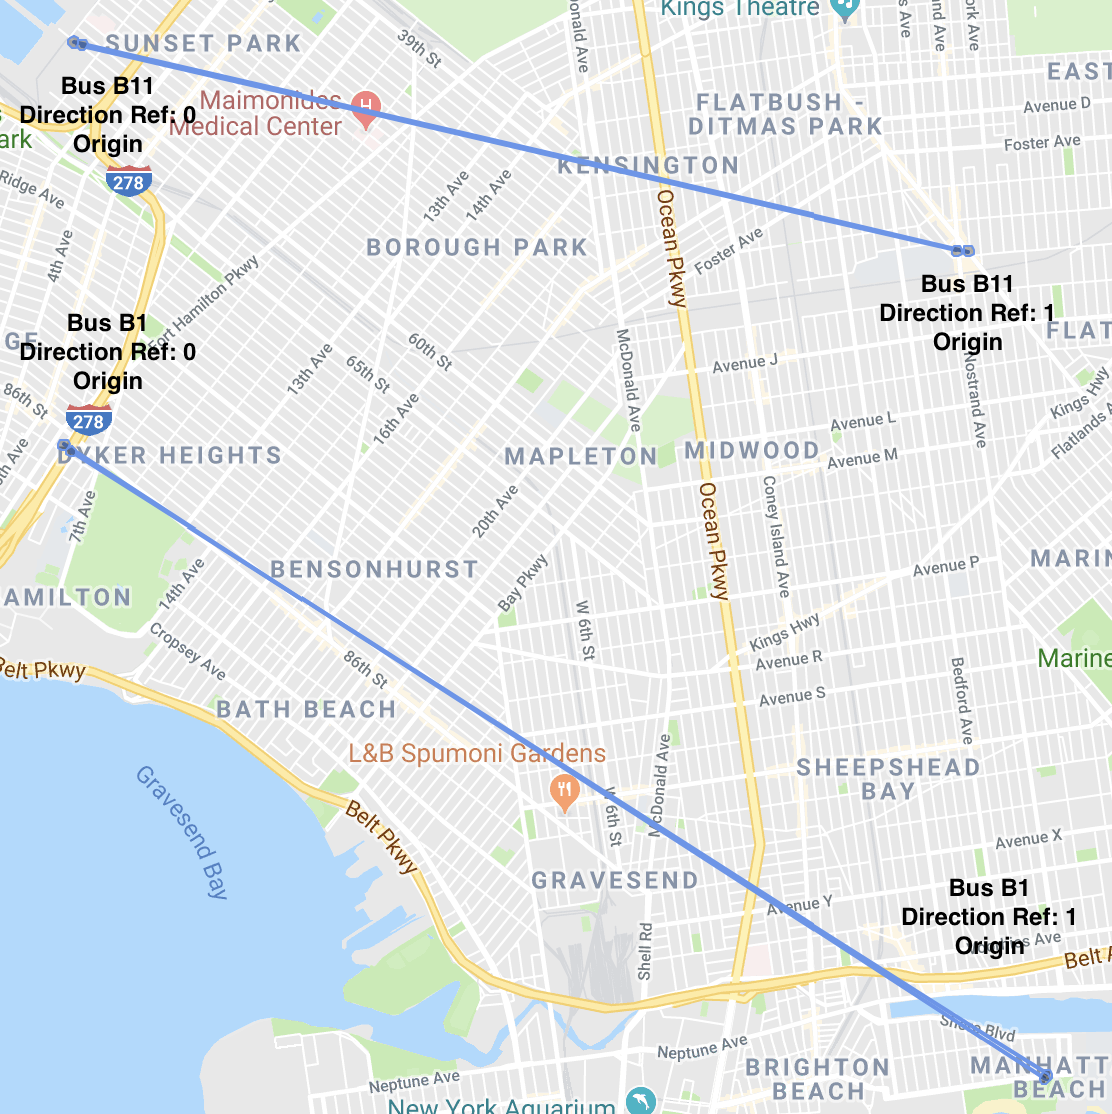

In [27]:
Image(filename='Paths for B1 and B11.png')

### Step 4: Summarizing the data and gathering useful columns

I wanted to plot the spread of delays. I felt that it would be diffcult to visualize with over 5 million points and easier if the data is summarized. Each bus has one line in the summarized data called 'subsetdata'. To obtain this view, we group the original dataset by 'PublishedLineName', which is the bus number, collecting the mean values for each bus.

In [28]:
subsetdata = dataset.groupby(['PublishedLineName']).mean()

In [29]:
subsetdata = subsetdata.drop(['DirectionRef', 'VehicleLocation.Latitude','VehicleLocation.Longitude' ,'DistanceFromStop'], axis=1)

The summarized dataset contains 236 rows. 

In [30]:
subsetdata.head()

OriginLat  OriginLong  DestinationLat  DestinationLong  \
PublishedLineName                                                           
B1                 40.598386  -73.981201       40.598974       -73.982877   
B11                40.638170  -73.981756       40.639350       -73.988603   
B12                40.664620  -73.934195       40.667053       -73.927262   
B13                40.680297  -73.899685       40.676795       -73.896613   
B14                40.666489  -73.895191       40.666704       -73.899165   

                   Delay_Seconds  Delay_Minutes  
PublishedLineName                                
B1                   -251.303616      -4.191034  
B11                  -285.549412      -4.759434  
B12                  -544.735326      -9.078228  
B13                  -396.934392      -6.614625  
B14                  -362.126622      -6.034707

**The spread tells us the average delay for most buses is between 3 minutes and 7 minutes.** <br>
There are several points scattered between 3 minutes and 7 minutes, making some portions look like a solid line rather than a set of points. 

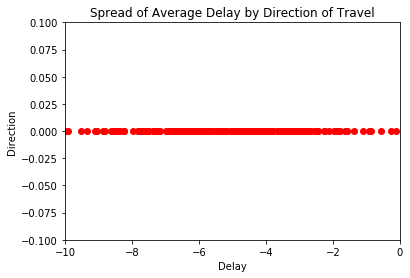

In [31]:
ar = subsetdata['Delay_Minutes']
val = 0. 
plt.plot(ar, np.zeros_like(ar) + val, 'ro', markersize=6)
plt.ylim(ymin=-0.1,ymax=0.1)
plt.xlim(xmin=-10,xmax=0)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 4
plt.xlabel('Delay')
plt.ylabel('Direction')
plt.title('Spread of Average Delay by Direction of Travel')
plt.show()

### Step 5: What are the top 3 buses with the longest delays on average?

Bus M7 had the longest delay of 11.1 minutes, followed by bus Q56 and M55.

Bus routes:

M7: Harlem - 14th Street and back <br>
Q56: Broadway Junction - Jamaica and back <br>
M55: W 44 St - South Ferry and back <br>

So then we know that the 3 most delayed buses on average are not traveling on the same path. 

In [32]:
subsetdata.nsmallest(3,['Delay_Minutes'])

OriginLat  OriginLong  DestinationLat  DestinationLong  \
PublishedLineName                                                           
M7                 40.776033  -73.968704       40.782788       -73.963735   
Q56                40.692192  -73.849117       40.693733       -73.844212   
M55                40.727566  -73.998812       40.730770       -73.997124   

                   Delay_Seconds  Delay_Minutes  
PublishedLineName                                
M7                   -668.766174     -11.145609  
Q56                  -663.078785     -11.051259  
M55                  -642.249781     -10.702326

### Step 6: What was the most common delay?

Most frequent delay was approximately 5 minutes (delayed rounded to 1 decimal point) and it happened for 46 out of 236 instances.

*Note that this finding aligns with the spread of average delay we plotted earlier, where the 3 to 7 minute region had the most delays.*

In [33]:
round(subsetdata['Delay_Minutes'],0).mode()

0   -5.0
dtype: float64

In [34]:
count = 0
for i in range (len(subsetdata)):
    if (round(subsetdata['Delay_Minutes'][i],0) == -5.0):
        count = count + 1
print(count)

46


# Conclusion

K-Nearest Neighbors could not be used to classify bus data into groups for further analysis as most column attributes are close in value to each other. This prevents us from developing a model that predicts bus delays.

Manhattan has the greatest number of buses in all of New York City. Average bus delay is New York City is 5.7 minutes and the most common bus delay is approximately 5 minutes. Buses M7, Q56 and M55 were delayed the most in June 2017.

Next Steps: <br>
Explore different clustering algorithms in the future.